# New Section

In [1]:
!pip install torch
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os                                     
import google.colab                           
                                   
# mounting Google Drive in the runtime's virtual machine

if not os.path.isdir('/content/drive'):

    google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Research with Fahad Sir/Dataset/Dataset.csv')

# for barkat
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bangla Bert/Dataset/Dataset.csv') 

df.shape

(36000, 7)

In [7]:
df

,SL,Emotion,Text,Year,Racial Biases,Hatred Percentage,Depression Percentage
0,1,disgust,নির্বাচনের আগের রাতে সুষ্টু শান্তিপূর্ণ ভাবে ভ...,2016,NaN,NaN,NaN
1,2,disgust,জনগণ মনের আনন্দে নিজেদের ভোট কাস্ট করে দেশদ্রো...,2016,NaN,NaN,NaN
2,3,angry,ভেজাল নির্বাচন ।,2016,NaN,NaN,NaN
3,4,happy,বিএনপি ও রাজাকার সমর্থকরা হেরে গেলে দেশের জন্য...,2016,NaN,NaN,NaN
4,5,angry,"সূক্ষ্ম কারচুপি বলে এতদিন একটা কথার কথা ছিল, এ...",2016,NaN,NaN,NaN
...,...,...,...,...,...,...,...
35995,35996,surprise,ভারতের মতো একটা বিশাল দেশে এত অঙ্গরাজ্য যে সব ...,2021,NaN,NaN,NaN
35996,35997,surprise,"২৪, ৫০, এমনকি কারো কারো মতে ৬০ জন।",2021,NaN,NaN,NaN
35997,35998,surprise,এদের মধ্য থেকে ২৭ জনকে রাজা বিয়ে দিয়েছিল চন্দ্...,2021,NaN,NaN,NaN
35998,35999,surprise,"ওয়াকফের শাব্দিক অর্থ কোনো কিছু আটকে রাখা, উৎসর...",2021,NaN,NaN,NaN


In [8]:
df = df.drop(["Year", "Racial Biases",	"Hatred Percentage",	"Depression Percentage"], axis=1)

In [9]:
df

,SL,Emotion,Text
0,1,disgust,নির্বাচনের আগের রাতে সুষ্টু শান্তিপূর্ণ ভাবে ভ...
1,2,disgust,জনগণ মনের আনন্দে নিজেদের ভোট কাস্ট করে দেশদ্রো...
2,3,angry,ভেজাল নির্বাচন ।
3,4,happy,বিএনপি ও রাজাকার সমর্থকরা হেরে গেলে দেশের জন্য...
4,5,angry,"সূক্ষ্ম কারচুপি বলে এতদিন একটা কথার কথা ছিল, এ..."
...,...,...,...
35995,35996,surprise,ভারতের মতো একটা বিশাল দেশে এত অঙ্গরাজ্য যে সব ...
35996,35997,surprise,"২৪, ৫০, এমনকি কারো কারো মতে ৬০ জন।"
35997,35998,surprise,এদের মধ্য থেকে ২৭ জনকে রাজা বিয়ে দিয়েছিল চন্দ্...
35998,35999,surprise,"ওয়াকফের শাব্দিক অর্থ কোনো কিছু আটকে রাখা, উৎসর..."


In [ ]:
# Let's have a look at the class balance.
sns.countplot(df.Emotion)
plt.xlabel('Emotion');

Data Preprocessing

In [10]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [12]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.Text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

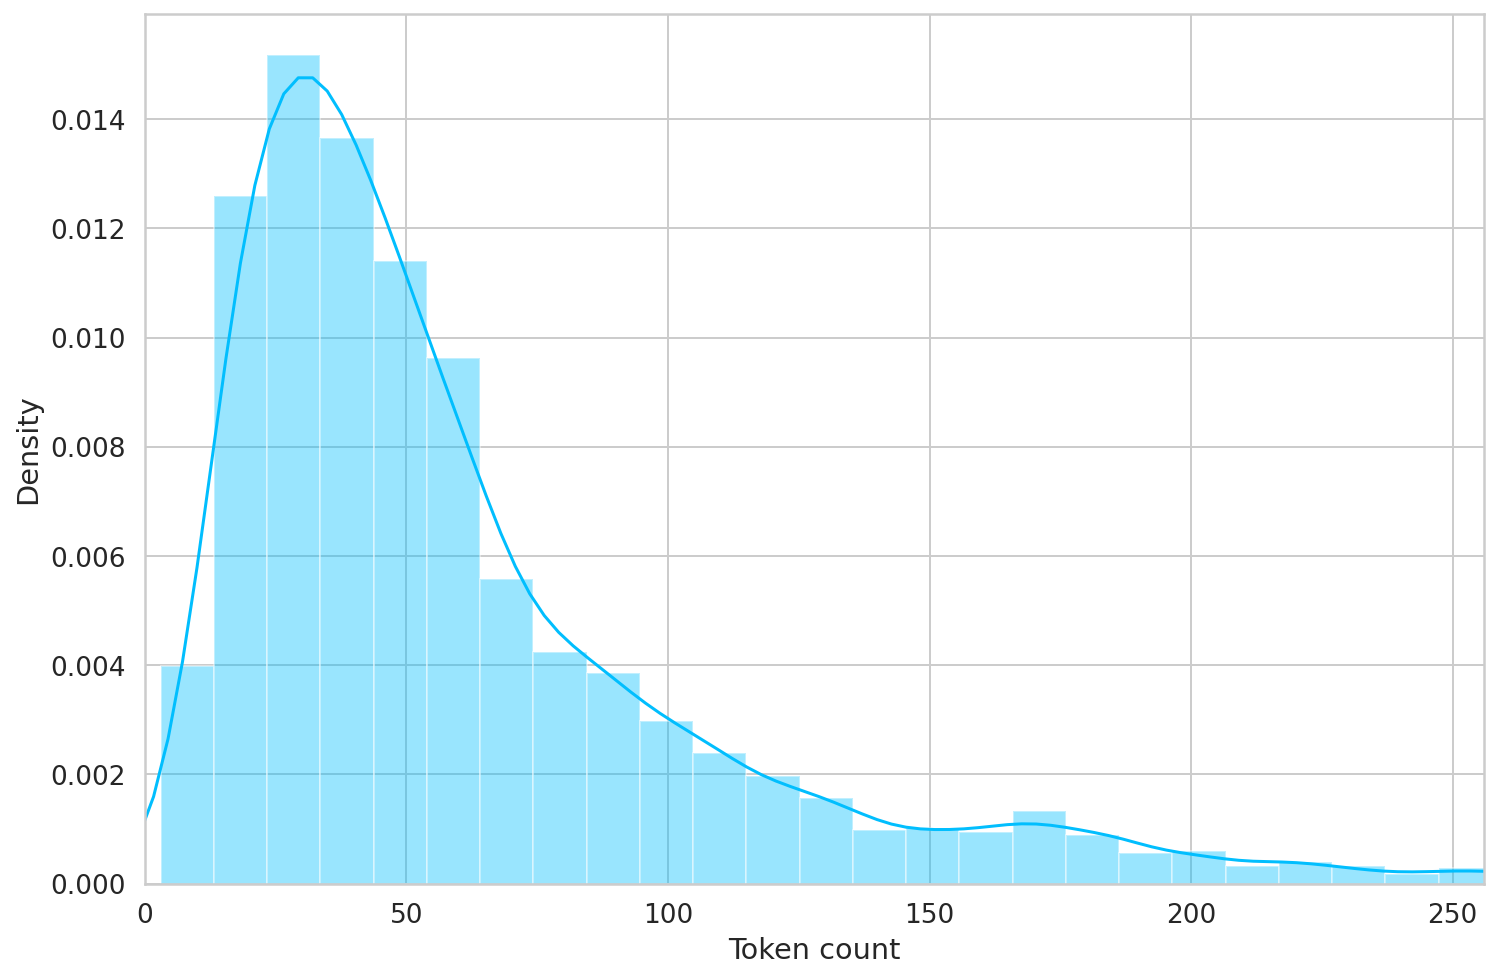

In [13]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [14]:
MAX_LEN = 160

Preparing Torch Dataset

In [15]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(28800, 3) (3600, 3) (3600, 3)


In [18]:
df_train

,SL,Emotion,Text
2848,2849,4,একটি বিষয়ে শ্রদ্ধেয় কাবেরী গায়েনের সাথে সহমত প...
19402,19403,1,কি বিহিত চান এই চাষার দেশে কিছু হবেনা
13192,13193,4,৫ জানুয়ারির নির্বাচনের পর বিএনপি জোটের সরকারবি...
12680,12681,0,সাহস থাকলে নির্বাচনের ফলাফল প্রত্যাখান করুক নয়...
12540,12541,2,"যে দেশে একজন সংসদ সদস্য নিরাপদ নয়, সেখানে সাধা..."
...,...,...,...
16850,16851,2,ফেসবুক যারা ফ্লার্ট ও পরকীয়ার মাধ্যম হিসেবে ব্...
6265,6266,4,"আগে বাংলাদেশ দল হারলে বলা হত, খেলোয়ারদের অভিজ..."
11284,11285,3,অভিযানের নাম বাংলায় রাখলে শ্রুতিমধুর হবে।
860,861,4,আমার মনে হয় উনি জানেন কারা রেলের স্প্রিণ্টার ত...


In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Text.to_numpy(),
        targets=df.Emotion.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [20]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [21]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [22]:
train_data_loader

In [23]:
# Examples 
 
data = next(iter(train_data_loader))
# data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


Sentiment Classification with BERT and Hugging Face

In [24]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)
 
# outputs = bert_model(**inputs, return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# bert_model = BertModel.from_pretrained("bert-base-cased", return_dict=False)
# outputs = bert_model(**inputs)

In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
class_names = ['disgust', 'angry', 'happy', 'surprise', 'fear', 'sad']

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


Training Phase

In [ ]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# %%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.8048614050944647 accuracy 0.16850694444444445
Val   loss 1.797023787498474 accuracy 0.1738888888888889

Epoch 2/10
----------
Train loss 1.805661409298579 accuracy 0.168125
Val   loss 1.7985126670201619 accuracy 0.1738888888888889

Epoch 3/10
----------
Train loss 1.801115426686075 accuracy 0.1684027777777778
Val   loss 1.7986270411809286 accuracy 0.1738888888888889

Epoch 4/10
----------
Train loss 1.800574805604087 accuracy 0.16618055555555555
Val   loss 1.7951955625745986 accuracy 0.1738888888888889

Epoch 5/10
----------
Train loss 1.797713558740086 accuracy 0.1684375
Val   loss 1.7942584535810682 accuracy 0.1738888888888889

Epoch 6/10
----------
Train loss 1.7972915569278929 accuracy 0.1635763888888889
Val   loss 1.7924989451302422 accuracy 0.1738888888888889

Epoch 7/10
----------
Train loss 1.7967580223083497 accuracy 0.16427083333333334
Val   loss 1.7917035166422526 accuracy 0.1663888888888889

Epoch 8/10
----------
Train loss 1.7955223995447